In [3]:
import matplotlib.pyplot as plt
import numpy as np

from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

dataroot='/data/Datasets/nuscenes'

nusc = NuScenes(version='v1.0-trainval', dataroot=dataroot, verbose=True)
nusc_map = NuScenesMap(dataroot=dataroot, map_name='singapore-onenorth')
nusc_can = NuScenesCanBus(dataroot=dataroot)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 33.603 seconds.
Reverse indexing ...
Done reverse indexing in 8.7 seconds.


af996db7-9024-4017-9d88-c78eef37f04d


/home/muyang/miniconda3/envs/nuscenes/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


(<Figure size 1012.5x792.8 with 2 Axes>,
 (<Axes:title={'center':'Global View'}>, <Axes:title={'center':'Local View'}>))

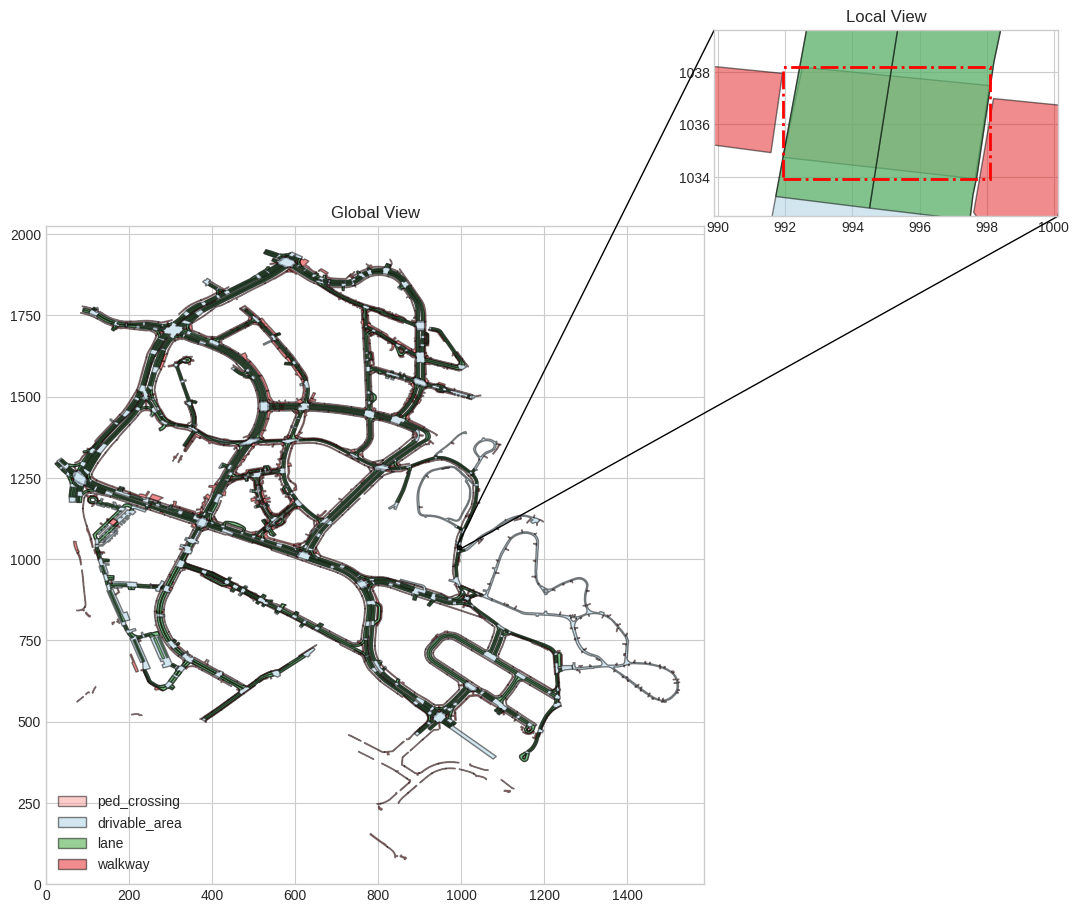

In [36]:
map_records = nusc_map.get_records_in_radius(1000,1000,100,layers,mode='intersect')
record = map_records['ped_crossing'][0]
print(record)
nusc_map.render_record('ped_crossing', record)

In [17]:
class ActionSegmenter:

    def __init__(self, straight_thresh=20, coast_thresh=0.5, stop_thresh=0.05, radius=100):
        #settings
        self.straight_thresh = straight_thresh # degree deadband for driving straight
        self.coast_thresh = coast_thresh # km/h deadband for driving at constant speed
        self.stop_thresh = stop_thresh #km/h thresh for being stopped
        self.radius = radius
        self.layers = nusc_map.non_geometric_layers
        self.can_features = ['steering', 'vehicle_speed']

        #dynamic variables
        self.actions = []
        self.core_data = []
        self.can_data = []

    def change_action(self, action, time):
        if not self.actions or self.actions[len(self.actions)-1]['label'] != action:
            self.actions.append({'label':action, 'time':time})
    
    def convert_utime_secs(self, data, start_utime):
        #convert to seconds
        #start_utime = data[0]['utime']
        for d in data:
            d['time'] = (d['utime'] - start_utime) * 1e-6
            del d['utime']
        return data

    
    def extract_CAN_data(self, scene_name, feature_names):
        feature_names.append('utime')
        raw_data = nusc_can.get_messages(scene_name, 'vehicle_monitor')
        data = [{k: i[k] for k in feature_names} for i in raw_data]
        return data
    
    #in this case only ego pose
    def extract_core_data(self, scene_name):
        scene = self.find_scenes_by_name(scene_name)[0]
        print(scene)
        first_sample_token = scene['first_sample_token']
        
        sample = nusc.get('sample', first_sample_token)
        data = []

        while True:
            sample_data_lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
            ego_pose = nusc.get('ego_pose', sample_data_lidar['ego_pose_token'])
            data.append({'pos':ego_pose['translation'][:2], 'utime':ego_pose['timestamp']})

            next_token = sample['next']
            if next_token == '':
                break
            sample = nusc.get('sample', next_token)

        return data



    def segment(self, scene_name):
        self.actions = []
        self.core_data = self.extract_core_data(scene_name)
        self.can_data = self.extract_CAN_data(scene_name, self.can_features)

        start_time = self.core_data[0]['utime'] # use the first can_data time as 0 seconds

        self.core_data = self.convert_utime_secs(self.core_data, start_time)
        self.can_data = self.convert_utime_secs(self.can_data, start_time)

        print('core length:', len(self.core_data))
        print('can length:', len(self.can_data))
        print(self.core_data)
        print(self.can_data)

        #init bookkeeping data
        last_speed = self.can_data[0]['vehicle_speed']

        #map_records = nusc_map.get_records_in_radius(1000,1000,self.radius,self.layers,mode='intersect')


        for d in self.can_data:
            action = 'none'
            speed = d['vehicle_speed']
            steer = d['steering']
            time = d['time']
            
            acceleration = speed - last_speed

            if speed < self.stop_thresh:
                action = 'stop'
            else:
                if abs(steer) < self.straight_thresh:
                    if abs(acceleration) < self.coast_thresh:
                        action = 'drive straight'
                    elif acceleration > 0:
                        action = 'accelerate'
                    elif acceleration < 0:
                        action = 'decelerate'
                elif steer > 0:
                    action = 'turn left'
                elif steer < 0:
                    action = 'turn right'


            #update bookkeeping
            last_speed = speed

            self.change_action(action, time)

        self.actions.append({'label':'END', 'time':self.can_data[len(self.can_data)-1]['time']})
        return self.actions



    def find_scenes_by_name(self, name):
        return [ i for i in nusc.scene if name in i['name'].lower() ]


In [21]:
scene_name = 'scene-0061'
seg = ActionSegmenter()
actions = seg.segment(scene_name)
print(actions)
plot_actions(seg)

{'token': 'cc8c0bf57f984915a77078b10eb33198', 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2', 'nbr_samples': 39, 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5', 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0', 'name': 'scene-0061', 'description': 'Parked truck, construction, intersection, turn left, following a van'}
core length: 39
can length: 38
[{'pos': [411.3039349319818, 1180.8903791765097], 'time': 0.0}, {'pos': [409.7431520488096, 1176.6769733781416], 'time': 0.49989599999999995}, {'pos': [408.101879146712, 1172.1515777892457], 'time': 1.050097}, {'pos': [406.7260055966978, 1168.2112865775816], 'time': 1.549402}, {'pos': [405.40940618082874, 1164.3542269452469], 'time': 2.049846}, {'pos': [404.27766613575534, 1161.0501064609266], 'time': 2.50465}, {'pos': [403.1147868052399, 1157.5179992427084], 'time': 3.000374}, {'pos': [401.882035855894, 1153.723115401486], 'time': 3.55056}, {'pos': [400.84139513617623, 1150.4041654308548], 'time': 4.049882}, {'pos': [399.8

[{'label': 'drive straight', 'time': 0.47984899999999997},
 {'label': 'decelerate', 'time': 0.979208},
 {'label': 'turn left', 'time': 5.479375999999999},
 {'label': 'drive straight', 'time': 14.978660999999999},
 {'label': 'turn left', 'time': 16.979402},
 {'label': 'END', 'time': 19.479108999999998}]

[(0.47984899999999997, 0.979208, 'blue'), (0.979208, 5.479375999999999, 'yellow'), (5.479375999999999, 14.978660999999999, 'orange'), (14.978660999999999, 16.979402, 'blue'), (16.979402, 19.479108999999998, 'orange')]


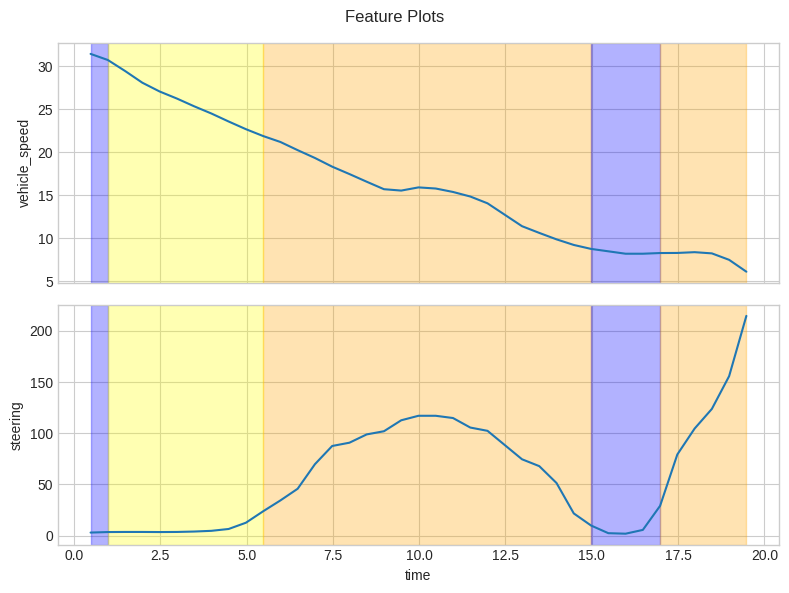

In [22]:
# PLOTTING

def plot_actions(seg):
    # create action period
    colors = {'stop':'red', 'drive straight':'blue', 'accelerate':'green', 'decelerate':'yellow', 'turn left':'orange', 'turn right':'magenta'}
    periods = []
    for i in range(len(actions)-1):
        from_time = actions[i]['time']
        '''
        if i == len(actions)-1:
            to_time = data[len(data)-1]['time']
        else:
            to_time = actions[i+1]['time']
        '''
        to_time = actions[i+1]['time']
        color = colors[actions[i]['label']]
        periods.append((from_time, to_time, color))
    print(periods)

    xlabel = 'time'

    # Extract unique feature keys
    feature_keys = list(set().union(*(d.keys() for d in seg.can_data)))
    feature_keys.remove(xlabel)  # Remove 'timestamp' key

    # Create a figure with subplots
    num_subplots = len(feature_keys)
    fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 3 * num_subplots), sharex=True)

    # Plot each feature in a separate subplot
    for i, feature in enumerate(feature_keys):
        x = [d[xlabel] for d in seg.can_data]
        feature_values = [d[feature] for d in seg.can_data]
        
        if num_subplots == 1:
            ax = axs
        else:
            ax = axs[i]

        for start, end, color in periods:
            ax.axvspan(start, end, alpha=0.3, color=color)

        ax.plot(x, feature_values)
        ax.set_ylabel(feature)

    # Set x-axis label and title
    axs[-1].set_xlabel(xlabel)
    fig.suptitle('Feature Plots')

    plt.tight_layout()
    plt.show()